In [1]:
# get rid of the annoying ipython import cache
%load_ext autoreload
%autoreload 2

In [1]:
# Python
from __future__ import annotations
# External
from scipy.stats import uniform, randint
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection as sklms
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt

## Load data and Pipeline
Reset pipeline fitting just in case (the pipeline is stored prefitted on the whole
dataset, ready for production server).
Drop points where the target variable is missing.
Stratify by Y because of imbalance.

In [2]:
data = pd.read_pickle('core/loading/listings.pkl.gzip')
pipeline = joblib.load('core/preprocessing/pipeline.joblib')
pipeline.fit(data.iloc[:1])
data = data.drop(data[data['transacted'].isna()].index).astype({'transacted':'uint8'}) # drop unknown values

In [3]:
columns_Y = ['transacted']
columns_X = [column for column in data.columns]
X, Y = data[columns_X], data[columns_Y]
X_train, X_test, Y_train, Y_test = sklms.train_test_split(X, Y, test_size=0.2,
                                                          shuffle=True, stratify=Y)

## Model Selection
For scoring choose F1, because it combines precision and recall.

In [16]:
def metrics(costs):
    costs = np.array(costs)
    return costs.mean().round(2), costs.std().round(2)

In [17]:
model = DummyClassifier(strategy='warn')
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='f1', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


(0.2, 0.01)

In [18]:
model = Pipeline([
    ('transform', pipeline),
    ('predict', RandomForestClassifier())
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='f1', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.5s finished


(0.85, 0.01)

In [20]:
model = Pipeline([
    ('transform', pipeline),
    ('predict', xgb.XGBClassifier(objective='binary:logistic'))
])
scores = sklms.cross_val_score(model, X_train, Y_train,
                               scoring='f1', cv=5, n_jobs=-1, verbose=2)
metrics(scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.3s finished


(0.86, 0.0)

## Evaluation

In [25]:
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(pipeline.fit_transform(X_train), Y_train)

/home/ilia/Desktop/projects/PropertyFinder/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
prediction = model.predict(pipeline.transform(X_test))

In [30]:
print('Accuracy', accuracy_score(Y_test, prediction))
print('F1', f1_score(Y_test, prediction))
print('Precision', precision_score(Y_test, prediction))
print('Recall', recall_score(Y_test, prediction))

Accuracy 0.9452408734789132
F1 0.8574528097201128
Precision 0.8747233289065959
Recall 0.8408510638297872


Performance of the final model.
The model can predict whether the real estate property will be transacted within one
month with 95% accuracy.
Precision and Recall are also quite high. Whenever model says the property gonna be transacted
it's correct in 87.5% times. The model is able to recognize 84% of transacted properties among all properties.
So if we give the model 100 properties that will be transacted, the model finds 84 of them.

## Final Model

In [4]:
model = xgb.XGBClassifier(objective='binary:logistic')
features = pd.DataFrame(pipeline.fit_transform(X), columns=pipeline.get_feature_names())
target = Y
model.fit(features, target)

/home/ilia/Desktop/projects/PropertyFinder/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Quick Look Inside the Model

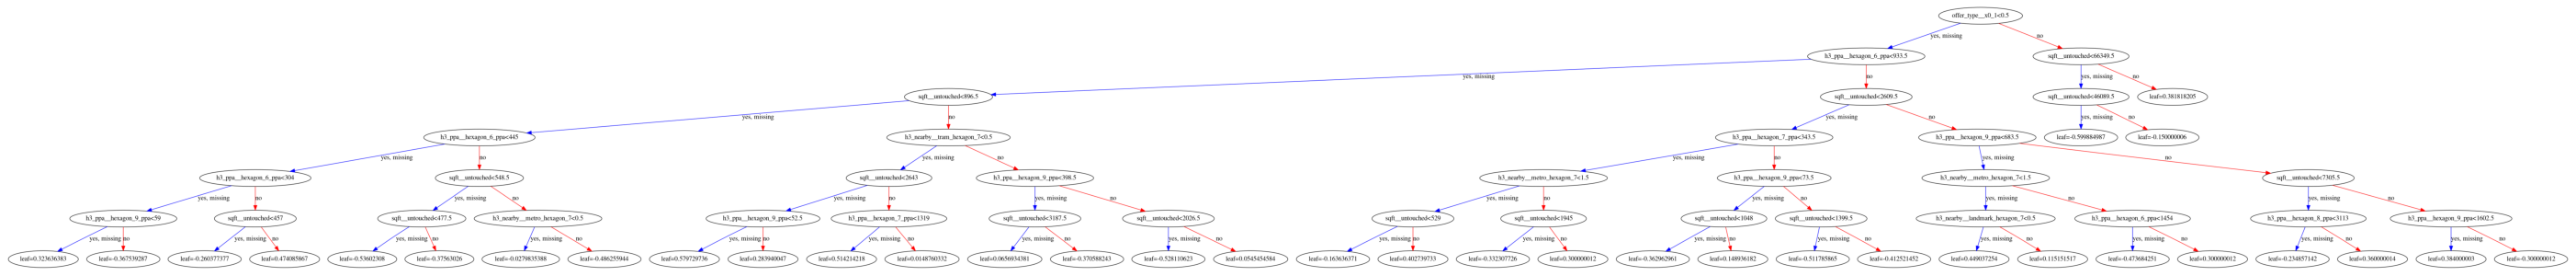

In [42]:
xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

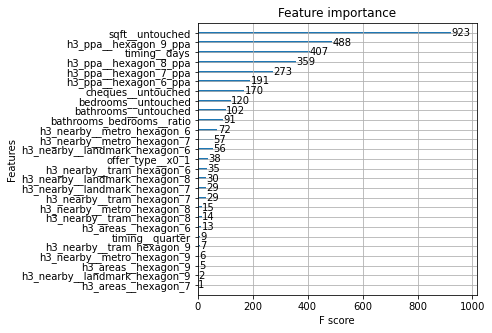

In [40]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Dump

In [5]:
joblib.dump(model, 'core/models/transacted.joblib', protocol=4)

['core/models/transacted.joblib']

## What could be done better?
Models:
- Stacking, layers
- Try out NN's
- Try out more algorithms
- HyperParam optimization
- Include price into prediction
- Generate features specifically for this model
